In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline


### We are going to look at the following:


* Exploratory analysis
    * Shape of the data
    * Figure out missing data
* Quick and fast prediction with random forests.
* Perform K-Fold validation to get a more robust score.
* Feature importance
* What important data is missing?
* How can we improve the data?
* Optimize the classification parameters
* Prepare a submit file


### First let's load the data and do a little bit of exploration

In [2]:
train = pd.read_csv('train.csv')
print("Number of rows: %d" % (train.shape[0]))
print("Number of columns: %d" % (train.shape[1]))
train.head()

Number of rows: 891
Number of columns: 12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### A quick look shows that cabin and age are often missing

In [3]:
# Count the number of missing Cabin and age  values
cabin_nan_count = train[train['Cabin'].isnull()]['PassengerId'].count()
age_nan_count = train[train['Age'].isnull()]['PassengerId'].count()
print("There are %d missing cabin values and %d missing age values" % (cabin_nan_count, age_nan_count))

train[train.isnull().any(axis=1)].head(20)

There are 687 missing cabin values and 177 missing age values


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S


**What is apparent at this point:**

* We cannot use the name and ticket features AS IS for classification.
* A lot of cabin and age entries are missing
* The PassengerId doesn't help for classification



### Let's do a quick RandomForest classification to set a baseline

In [4]:
# The following 2 functions are just useful:

# Drop all the columns in a list of column names 
def drop_columns(df, col_names):    
    for col in col_names:
        try:
            df = df.drop(col, axis=1)
        except:
            pass
    return df

# Encode a list of features
def encode_features(df, col_names):  
    from sklearn import preprocessing
    labelEncoder = preprocessing.LabelEncoder()
    for col in col_names:
        try:
            labelEncoder.fit(df[col])
            df[col] = labelEncoder.transform(df[col]) 
        except:
            pass
    return df

We'll drop the features that we cannot use and encode categorical features.  
At this point we won't care mucha bout losing some data because we are just trying to set a baseline.

In [5]:
train = pd.read_csv('train.csv')
train = drop_columns(train, ['PassengerId', 'Ticket', 'Name', 'Cabin'])
train = encode_features(train, ['Sex', 'Embarked'])
train = train.dropna()

# Check that we have not lost too much data:
train.shape

c:\users\owner\appdata\local\enthought\canopy\user\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
c:\users\owner\appdata\local\enthought\canopy\user\lib\site-packages\numpy\lib\arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


(714, 8)

Let's run a RandomForest classifier on this data:

In [6]:
from sklearn.cross_validation import train_test_split

y = train['Survived']
X = train.drop('Survived', axis= 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41)
rf = RandomForestClassifier(n_estimators=100,  max_depth=3)
#rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
print (rf.score(X_test, y_test), rf.score(X_train, y_train))

(0.81564245810055869, 0.82056074766355136)


- This result is not bad considering that there was no feature engineering up to this point.  
- But we lost some rows when we dropped the nan values, so the classification could be better.


## We should perform K-Fold validation to find a more reliable score

In [7]:
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem
def mean_score(scores):
    return ("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores))

cv = KFold(X.shape[0], 10, shuffle=True, random_state=41)
scores = cross_val_score(rf, X, y, cv=cv)
print (mean_score(scores))

Mean score: 0.798 (+/-0.013)


# Is age relevant to predict survival at the Titanic?
In the baseline classification I removed a lot of columns because they had an undefined age.  

I'll use RandomForests to get feature importance values.

In [8]:
# This function will return two lists:
#   features:       A list of feature names
#   f_importances:  A list of float values that indicate how important the respective feature is.
#
def get_feature_importance(rf, df):
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    indices, importances
    features = []
    f_importance = []
    for f in range(df.shape[1]):
        #print("%s. feature %d (%f)" % (X.columns[f], indices[f], importances[indices[f]]))
        features.append(df.columns[f])
        f_importance.append(importances[indices[f]])
    return [features, f_importance]

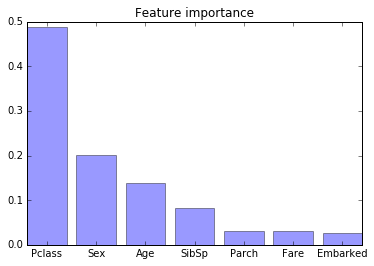

In [9]:
features, importances = get_feature_importance(rf, X)


# This function returns a plot for the feature importances
#
def get_feature_importance_plot():
    import matplotlib.pyplot as plt
    plt.figure()
    plt.title("Feature importance")

    # set the locations and labels of the xticks
    plt.xticks( range(len(features)), features)

    plt.bar(range(len(features)), importances, color="b",  align="center", alpha = 0.4)
    return plt

plt = get_feature_importance_plot()
plt.show()


## Age seems to be important, so let's estimate it 

Since the age is often missing and is also one of the most important features, we should estimate it.  
I noticed that names with title Master. are young, while Mr. is often not so young, so I will use the title to estimate the age of the passenger.

In [10]:
# Let's set the age based on the title: Mr. Mrs. Master, etc.
def set_titles(df):
    titles = ['Master.', 'Mr. ', 'Miss.', 'Mrs', 'Rev.', 'Dr']  #There are also Sir, Rev, Dr, and Ms, but we'll assume they are all adults
    regex_titles = [ r'.*(Master\.).*',  r'.*(Mr\.).*',  r'.*(Miss\.).*',  r'.*(Mrs\.).*',  r'.*(Rev\.).*',  r'.*(Dr\.).*']
    df['Title'] = 'Mr.'
    i=0
    for title in titles:
        regex = regex_titles[i]
        df.loc[df['Name'].str.contains(regex),['Title']] = title
        i = i + 1
    
    return df

def set_ages_based_on_title(df):
    titles = ['Master.', 'Mr. ', 'Miss.', 'Mrs', 'Rev.', 'Dr']      
    for title in titles:
        median_age = df.loc[df['Title'].str.startswith(title) & df['Title'].str.startswith(title), ['Age']].median()
        df.loc[(pd.isnull(df['Age'])==True) & (df['Title'].str.startswith(title)), ['Age']] = float(median_age)
    return df
        

In [11]:
def preprocess_improved(df, target_included=True):
    # Drop the columns that clearly don't influence the decision
    X = df
    X = X.drop('PassengerId', axis= 1)
    X = X.drop('Ticket', axis= 1)
    # Set embarked to 'S' since it is the most common value.
    X["Embarked"] = X["Embarked"].fillna("S")
    X = set_titles(X)
    X = set_ages_based_on_title(X)
    X = X.drop('Name', axis= 1)
    
    # Non-numerical values are not accepted by scikit-learn - replace them with a label encoder
    X = encode_features(X, ['Embarked', 'Sex', 'Title', 'Cabin'])
    
    if (target_included):
        # Create the target DF and remove it from the training set
        y = X['Survived']
        X = X.drop('Survived', axis= 1)
        return (X, y)
    else:
        return X

train = pd.read_csv('train.csv')
X, y = preprocess_improved(train, target_included=True)
X.head()

c:\users\owner\appdata\local\enthought\canopy\user\lib\site-packages\ipykernel\__main__.py:9: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,3,1,22.0,1,0,7.2500,0,2,4
1,1,0,38.0,1,0,71.2833,82,0,5
2,3,0,26.0,0,0,7.9250,0,2,2
3,1,0,35.0,1,0,53.1000,56,2,5
4,3,1,35.0,0,0,8.0500,0,2,4


In [12]:
rf = RandomForestClassifier(n_estimators=100,  max_depth=3)
cv = KFold(X.shape[0], 10, shuffle=True, random_state=41)
scores = cross_val_score(rf, X, y, cv=cv)
print (mean_score(scores))

Mean score: 0.810 (+/-0.009)


### Find the best parameters for RandomForest classification

In [23]:
from sklearn import grid_search
from sklearn.cross_validation import train_test_split
cv = KFold(X.shape[0], 10, shuffle=True, random_state=41)
rf = RandomForestClassifier(max_features=7)
parameters = {'max_depth':[2,3,4,5,6,7,8]}

clf_grid = grid_search.GridSearchCV(rf, parameters, cv=cv)
clf_grid.fit(X, y)
print (clf_grid.grid_scores_)
print (clf_grid.best_estimator_ )

[mean: 0.78114, std: 0.02377, params: {'max_depth': 2}, mean: 0.82043, std: 0.03280, params: {'max_depth': 3}, mean: 0.81706, std: 0.03082, params: {'max_depth': 4}, mean: 0.83165, std: 0.02635, params: {'max_depth': 5}, mean: 0.82155, std: 0.03059, params: {'max_depth': 6}, mean: 0.82716, std: 0.03007, params: {'max_depth': 7}, mean: 0.83165, std: 0.02082, params: {'max_depth': 8}]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=7, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


## Prepare to submit

I think this is an acceptable first take at this data, so I'll create a submit file.

In [20]:
train = pd.read_csv('train.csv')
X, y = preprocess_improved(train, target_included=True)
test = pd.read_csv('test.csv')
coursera_X_test = preprocess_improved(test, target_included=False)
coursera_X_test[coursera_X_test.isnull().any(axis=1)]

c:\users\owner\appdata\local\enthought\canopy\user\lib\site-packages\ipykernel\__main__.py:9: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
88,3,0,NaN,0,0,7.75,0,1,3
152,3,1,60.5,0,0,NaN,0,2,4


Apparently a couple of rows have nulls.  I'll use median values to set them.

In [21]:
# One passenger is missing the fare - let's set it to the median
median_fare = coursera_X_test['Fare'].median()
coursera_X_test.loc[coursera_X_test.isnull().any(axis=1), ['Fare']] = median_fare

# One passenger is missing the age - let's set it to the median
median_age = coursera_X_test['Age'].median()
coursera_X_test.loc[coursera_X_test.isnull().any(axis=1), ['Age']] = median_age

Let's create a submit file.

In [22]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', n_estimators=10, max_depth=8)
rf.fit(X, y)
prediction = rf.predict(coursera_X_test)

pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": prediction
        }).to_csv("submit.csv", index=False)